In [1]:
import cloudy
import torch
import numpy as np
import vulky.datasets as datasets  # module containing some resources for examples.
import os
import matplotlib.pyplot as plt


pipeline = cloudy.create_pipeline('./test')
# pipeline.download_pretrained()

environment = torch.ones(32, 64, 3, device=pipeline.get_device())*0.1
environment[10,0] = 1000

settings = dict(
    camera_position = (np.cos(0.5) * 2.7, -1.0, np.sin(0.5) * 2.7),
    environment = environment,  # An HDR environment
    density_scale = 300,
    phase_g = 0.0,
    scattering_albedo = (0.96, 0.96, 0.96),
)
environment, environment_sampler = cloudy.environment_objects(settings['environment'])

def render_grid(g: torch.Tensor, samples: int = 128):
    return cloudy.scattered(g * settings['density_scale'],
                     camera_poses=cloudy.camera_poses(settings['camera_position']),
                     scattering_albedo=settings['scattering_albedo'],
                     environment=environment,
                     environment_sampler=environment_sampler,
                     phase_g=settings['phase_g'],
                     majorant=g.max() * settings['density_scale'],
                     # kwargs
                     width=512,  # image width in pixels
                     height=512,  # image height in pixels
                     jittered=True,  # rays pass through 
                     samples=samples,  # number of ray paths for the primal evaluation
                     samples_bw=8,  # number of ray paths for the gradients backprop
                     mode='sps'  # singular path-sampling is used instead of DRT.
                     )

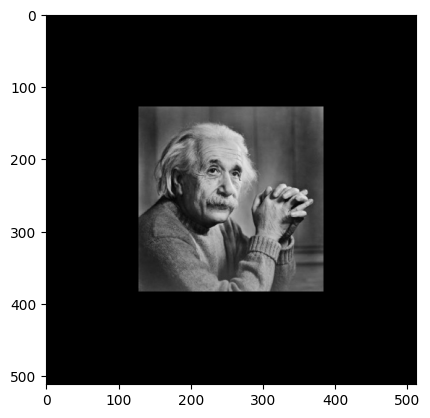

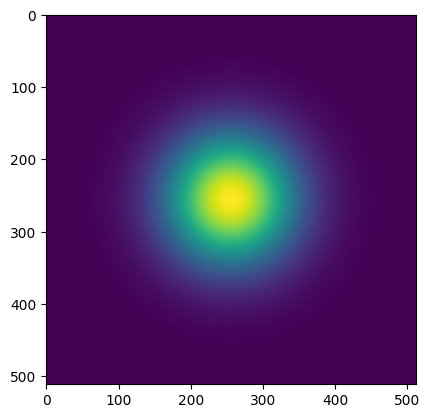

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


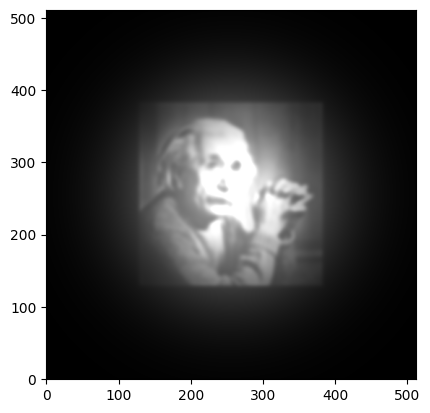

In [2]:
import torchvision

image = torchvision.io.image.read_image('./albert_einstein.jpg').permute(1,2,0).to(pipeline.get_device())/255.0
image = cloudy.resampling(image.unsqueeze(0), (256, 256))[0]

reference_image = torch.zeros(512, 512, 3, device=pipeline.get_device())
reference_image[128:-128, 128:-128] = image

plt.imshow(reference_image.cpu())
plt.show()

# create a gaussian saliency mask
x = torch.arange(-1.0, 1.000001, 2.0/(511), device=pipeline.get_device())
y = torch.arange(-1.0, 1.000001, 2.0/(511), device=pipeline.get_device())

g = torch.cartesian_prod(y, x)[:, [1,0]]
g = torch.exp(-8*(g[:,0:1]**2 + g[:,1:2]**2)).view(512, 512, 1)
plt.imshow(g.cpu())
plt.show()



reference_image = torch.flip(reference_image, dims=[0])
reference_image = cloudy.gaussian_filter(reference_image.unsqueeze(0), sigma=3.0, kernel_size=11)[0]
reference_image = ((torch.sigmoid((reference_image-0.5)*5) + 0.5) ** (2.2)) * g
plt.imshow(reference_image.cpu() ** (1.0/2.2))
plt.gca().invert_yaxis()
plt.show()


In [3]:
grid = pipeline.sample_volume(
    resolution=128,
    samples=100,
    scheduler_gamma=.8,
    guiding_strength=.6,
    y=reference_image.unsqueeze(0),
    A=lambda v: render_grid(v, samples=32)*g,
    ema_factor=0.2,
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


/home/leonard/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Posterior sampling DPS_DDIM: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Rendering captures: 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]


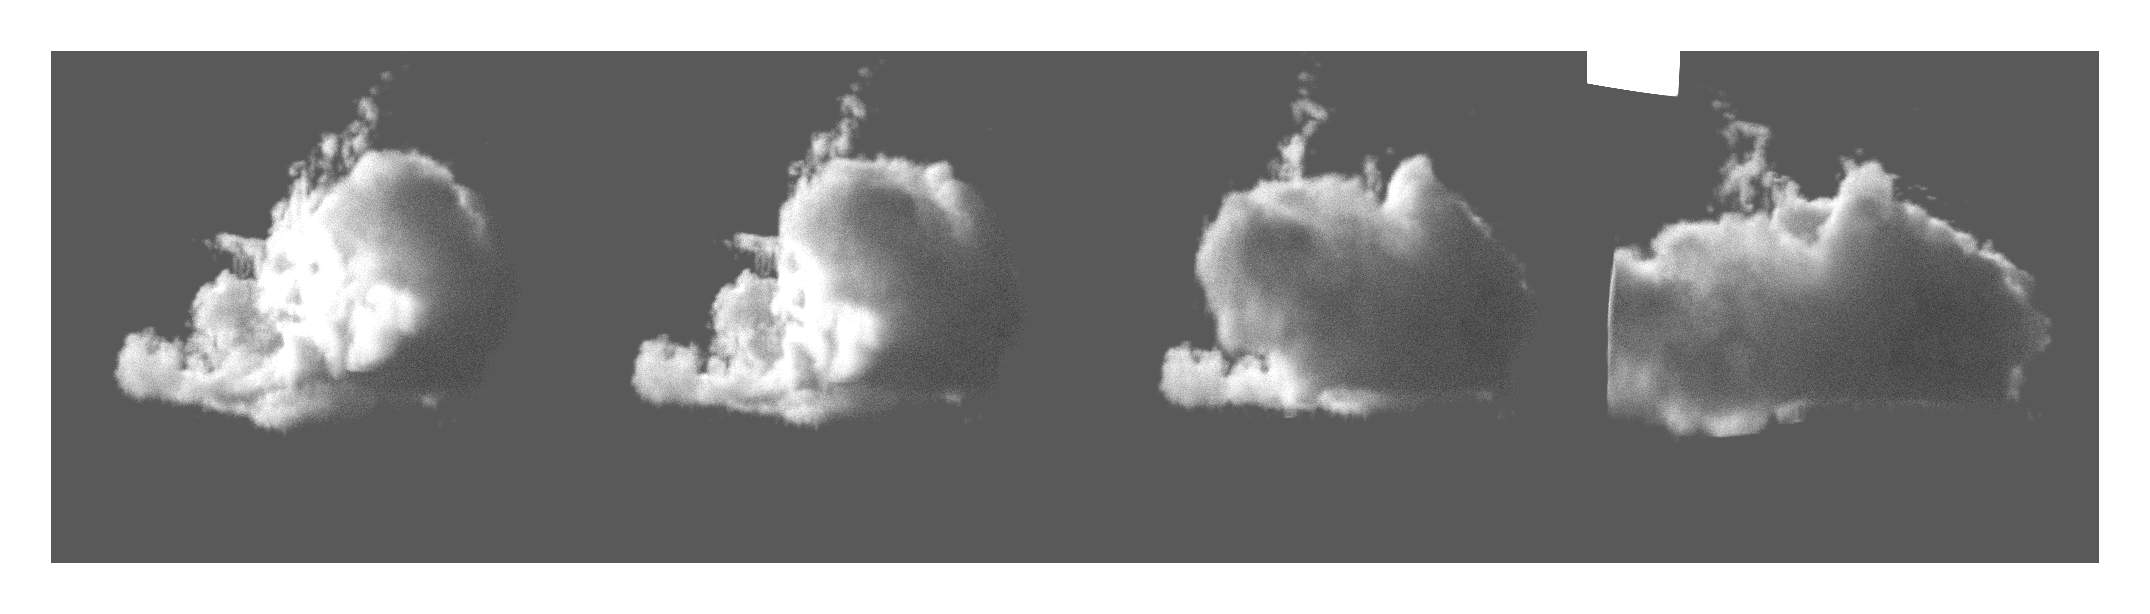

In [6]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
# saves the grid in the recorder to be used several times
grid_id = recorder.add_volume(grid)
# saves the environment tensor
env_id = recorder.add_environment(settings['environment'])
# capture multiple camera poses
for i in range(4):
    alpha = (i/4)**1.5
    recorder.new_keyframe(
        # Novel view for the sampled grid
        recorder.add_capture_volume(grid_id,
                                    environment=env_id,
                                    camera_position=(np.cos(0.5 + alpha)*2.7, -1.0 + alpha, np.sin(0.5 + alpha)*2.7),
                                    scattering_albedo=settings['scattering_albedo'],
                                    phase_g=settings['phase_g'],
                                    density_scale=settings['density_scale'],
                                    samples=128, render_mode='ms')        
    )
recorder.show_clip(4)

Rendering captures: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


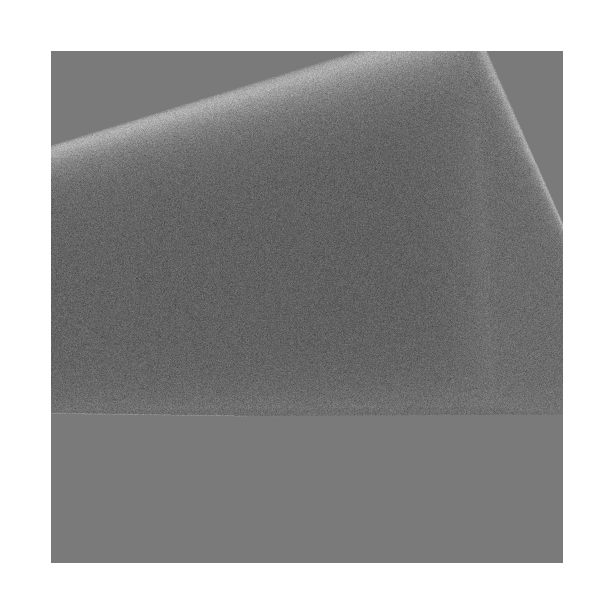

In [5]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
environment = torch.ones(32, 64, 3, device=pipeline.get_device())*0.2
environment[10,0] = 500
# saves the grid in the recorder to be used several times
grid_id = recorder.add_volume(grid)
# saves the environment tensor
env_id = recorder.add_environment(environment)
# capture multiple camera poses
recorder.new_keyframe(
    # Novel view for the sampled grid
    recorder.add_capture_volume(torch.ones(16, 8, 16, 1).to('cuda')*0.1,
                                environment=env_id,
                                camera_position=(np.cos(0.5)*2.7, -0.5, np.sin(0.5)*2.7),
                                scattering_albedo=settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=128, render_mode='ms')        
)
recorder.show_clip(1)